# Clase 6: Feature Engineering
## DP-100 Azure Data Scientist / DSRP
## Clase 16 Septiembre

### Dataset Utilizado: Hotel Booking

https://www.kaggle.com/code/touba7/hotel-booking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)

# CREDENCIALES AZURE
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
# METADATA ASSET
data_asset = ml_client.data.get("booking-dsrp", version="1")


Found the config file in: /config.json


In [2]:
# LEER DATA ASSET
dataframe_reservas_hotel_raw = pd.read_csv(data_asset.path)
dataframe_reservas_hotel_raw.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [34]:
dataframe_reservas_hotel_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [121]:
# ANALISIS DE LOS CLIENTES NUEVOS EN SU ADR
# ADR: https://www.investopedia.com/terms/a/average-daily-rate.asp#:~:text=The%20average%20daily%20rate%20(ADR)%20is%20a%20metric%20widely%20used,(KPI)%20of%20the%20industry.
dataframe_reservas_hotel_raw[dataframe_reservas_hotel_raw["is_repeated_guest"]==0].groupby("is_canceled").agg({"adr": [np.mean, np.min, np.max]})

adr             
                   mean  min     max
is_canceled                         
0            101.670375  0.0   510.0
1            105.357324  0.0  5400.0

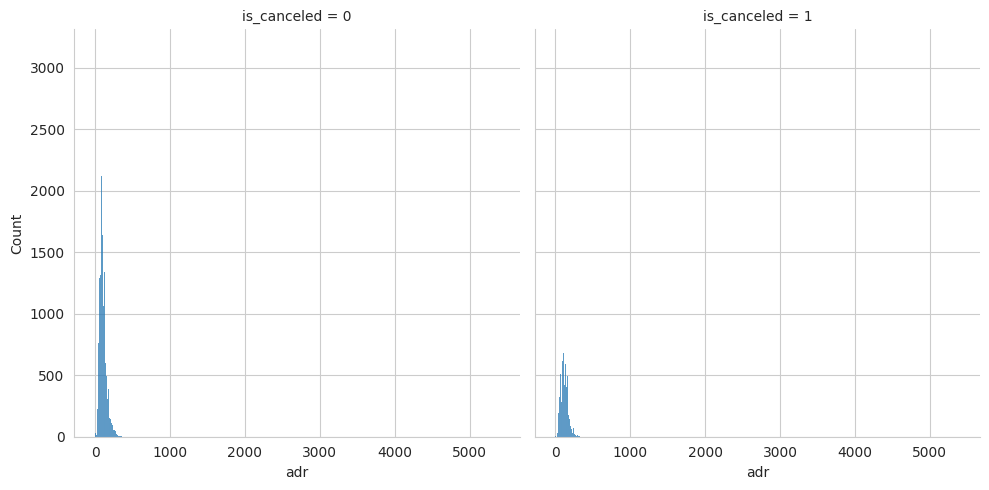

In [113]:
sns.displot(data=dataframe_reservas_hotel_raw, x="adr", col="is_canceled")

In [110]:
dataframe_reservas_hotel_raw["deposit_type"].value_counts()

No Deposit    104641
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64

In [123]:
dataframe_reservas_hotel_raw["reservation_status"].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

<Axes: xlabel='arrival_date_year', ylabel='count'>

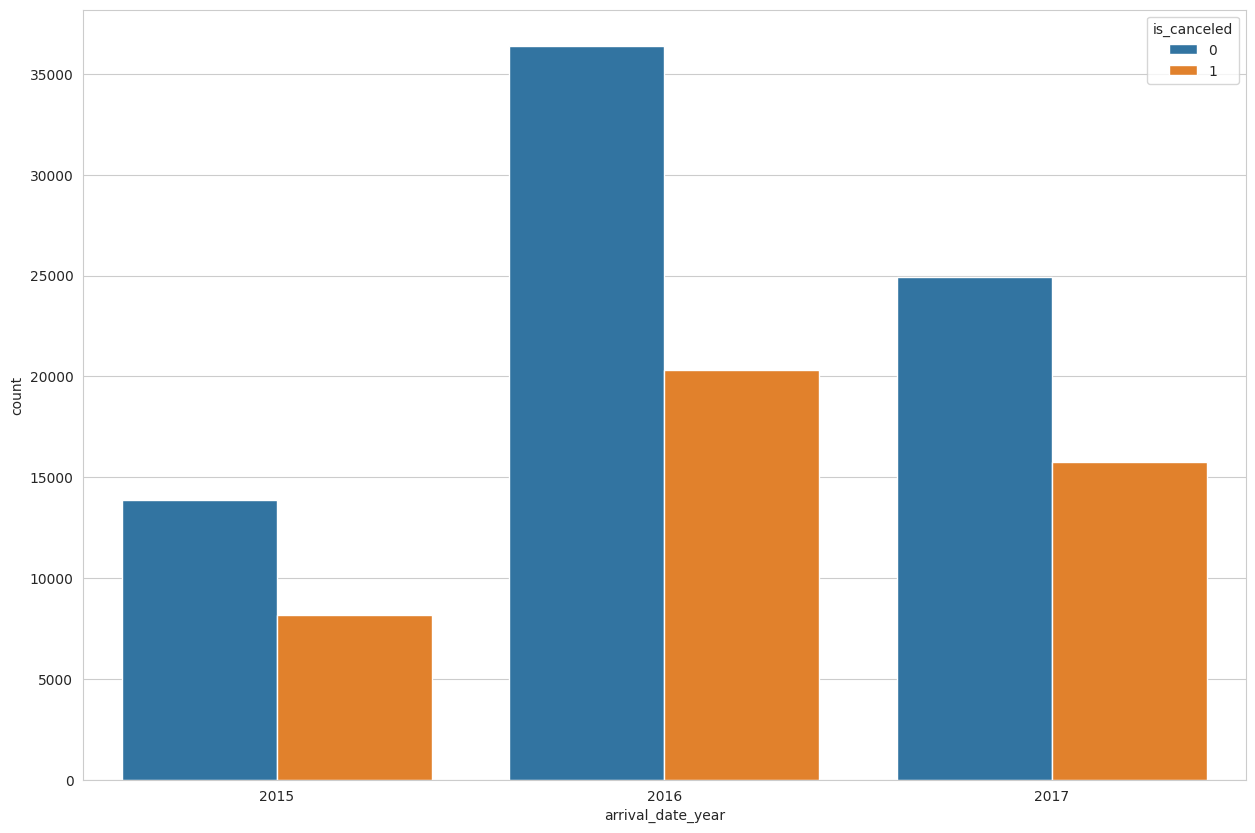

In [36]:
sns.countplot(data=dataframe_reservas_hotel_raw, x="arrival_date_year", hue="is_canceled")

Text(0.5, 1.0, 'Conteo Tipo de Hotel')

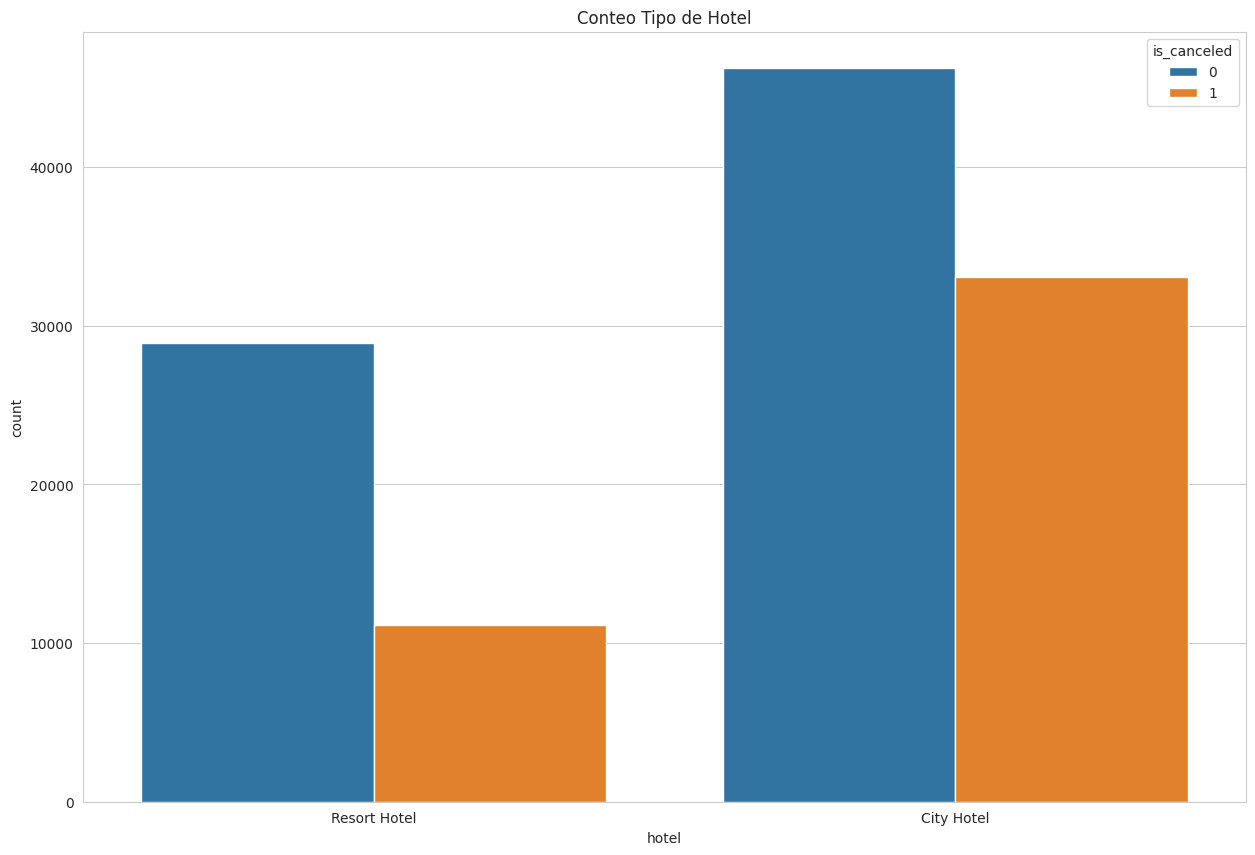

In [18]:
sns.countplot(data=dataframe_reservas_hotel_raw, x="hotel", hue="is_canceled")
plt.title("Conteo Tipo de Hotel")

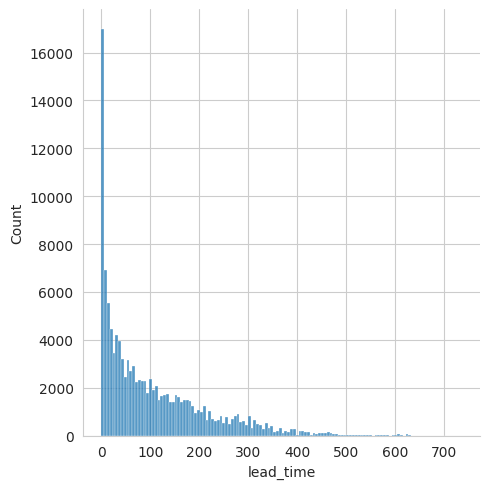

In [33]:
sns.displot(data=dataframe_reservas_hotel_raw, x="lead_time")

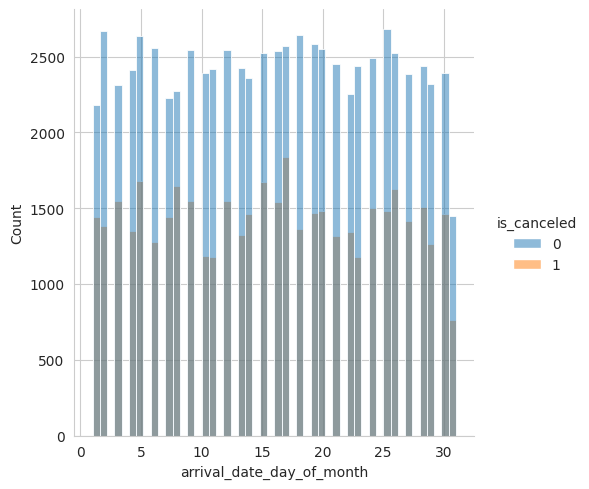

In [65]:
sns.displot(data=dataframe_reservas_hotel_raw, x="arrival_date_day_of_month", hue="is_canceled")

In [88]:
dataframe_reservas_hotel_raw["country"]

0         PRT
1         PRT
2         GBR
3         GBR
4         GBR
         ... 
119385    BEL
119386    FRA
119387    DEU
119388    GBR
119389    DEU
Name: country, Length: 119390, dtype: object

In [93]:
hasher = FeatureHasher(n_features=177,input_type="string")
_fitted_hasher = hasher.fit(dataframe_reservas_hotel_raw["country"])
_fitted_hasher.transform(dataframe_reservas_hotel_raw[["country"]])

ValueError: Samples can not be a single string. The input must be an iterable over iterables of strings.

In [84]:
dataframe_reservas_hotel_raw["country"].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
FJI        1
UMI        1
LCA        1
MRT        1
ASM        1
Name: country, Length: 177, dtype: int64

## Pipeline de procesamiento

In [20]:

from typing import List, Union

class DataProcessor:
    """
    Procesador de datos de Reservas de hoteles
    """

    def __init__(self, client: MLClient,  data: pd.DataFrame):
        self.client = client
        self.data = data


    def __encode_with_ohe(self, col_names: Union[str, List[str]]):
        """
        ONE HOT ENCODING DE CUALQUIER COLUMNA

        col_names: LIST DE COLUMNAS PARA APLICAR OHE
        """
        encoded_dfs = []
        for col in col_names:

            encoder = OneHotEncoder()
            fitted_encoder = encoder.fit(self.data[[col]])
            encoded_array = fitted_encoder.transform(self.data[[col]]).toarray()
            encoded_df = pd.DataFrame(encoded_array, columns= fitted_encoder.get_feature_names_out())
            encoded_dfs.append(encoded_df)

        return pd.concat(encoded_dfs, axis=1)


    def process(self):

        """
        PROCESAMIENTO PRINCIPAL
        """

        # VARIABLE QUE CALCULA SI EL HOTEL ESTA EN LA CIUDAD
        self.data["is_city_hotel"] = self.data["hotel"].apply(lambda x: int(x == "City Hotel"))
        self.data = self.data.drop("hotel", axis=1 )

         # CREAR DIFERENCIA ENTRE CUARTO RESERVADO Y CUARTO ASIGNADO
        self.data["diff_room"] = np.where(self.data["assigned_room_type"] == self.data["reserved_room_type"], 1, 0)


        # LISTA DE COLUMNAS PARA HACER ONE HOT ENCODDING 
        ohe_column_list = [
            "arrival_date_year", 
            "arrival_date_month",
            "meal",
            "market_segment",
            "distribution_channel", 
            "reserved_room_type",
            "deposit_type",
            "customer_type"
        ]

        encoded_dfs = self.__encode_with_ohe(col_names=ohe_column_list)
        self.data = pd.concat([self.data, encoded_dfs], axis=1)
        self.data = self.data.drop(ohe_column_list, axis=1)

        # IMPUTACION VARIABLE CHILDREN
        self.data["children"] = dataframe_reservas_hotel_raw["children"].fillna(0)

       

        # COLUMNAS QUE VAMOS A ELIMINAR
        drop_list = [
            "country", 
            "company", 
            "agent",
            "reservation_status", 
            "reservation_status_date",
            "name", 
            "email", 
            "phone-number", 
            "credit_card",
            "assigned_room_type"
        ]

        self.data = self.data.drop(drop_list, axis=1)

        # FEATURE SELECTOR - VARIANZA
        selector = VarianceThreshold()
        selected_variables = selector.fit_transform(self.data)

        print([ i for i in self.data.columns  if i not in selector.get_feature_names_out() ] )
        self.data = pd.DataFrame(selected_variables, columns=selector.get_feature_names_out())

        # STANDARDIZATION
        std_vars = ["lead_time", "adr", "days_in_waiting_list"]
        scales = []
        for col in std_vars:
            scaler = StandardScaler()  # OTROS METODOS MinMaxScaler, RobustScaler
            scaled_var = pd.DataFrame(
                scaler.fit_transform(dataframe_reservas_hotel_raw[col].to_numpy().reshape(-1, 1)), columns=[col]
            )
            scales.append(scaled_var)
        
        scales = pd.concat(scales, axis=1)
        self.data = self.data.drop(std_vars, axis=1)
        self.data = pd.concat([self.data, scales], axis=1)

    def write(self, version: int):

        PROCESSED_DATA_PATH = "feature_engineering_data_PROCESSED.csv"
        self.data.to_csv(PROCESSED_DATA_PATH,index=False)
        processed_dataset = Data(
            path=PROCESSED_DATA_PATH,
            type=AssetTypes.URI_FILE,
            description="Tabla Final Feature Engineering",
            name="gold-booking-dsrp",
            version=str(version)
        )
        self.client.data.create_or_update(processed_dataset)


<Axes: xlabel='adr', ylabel='Count'>

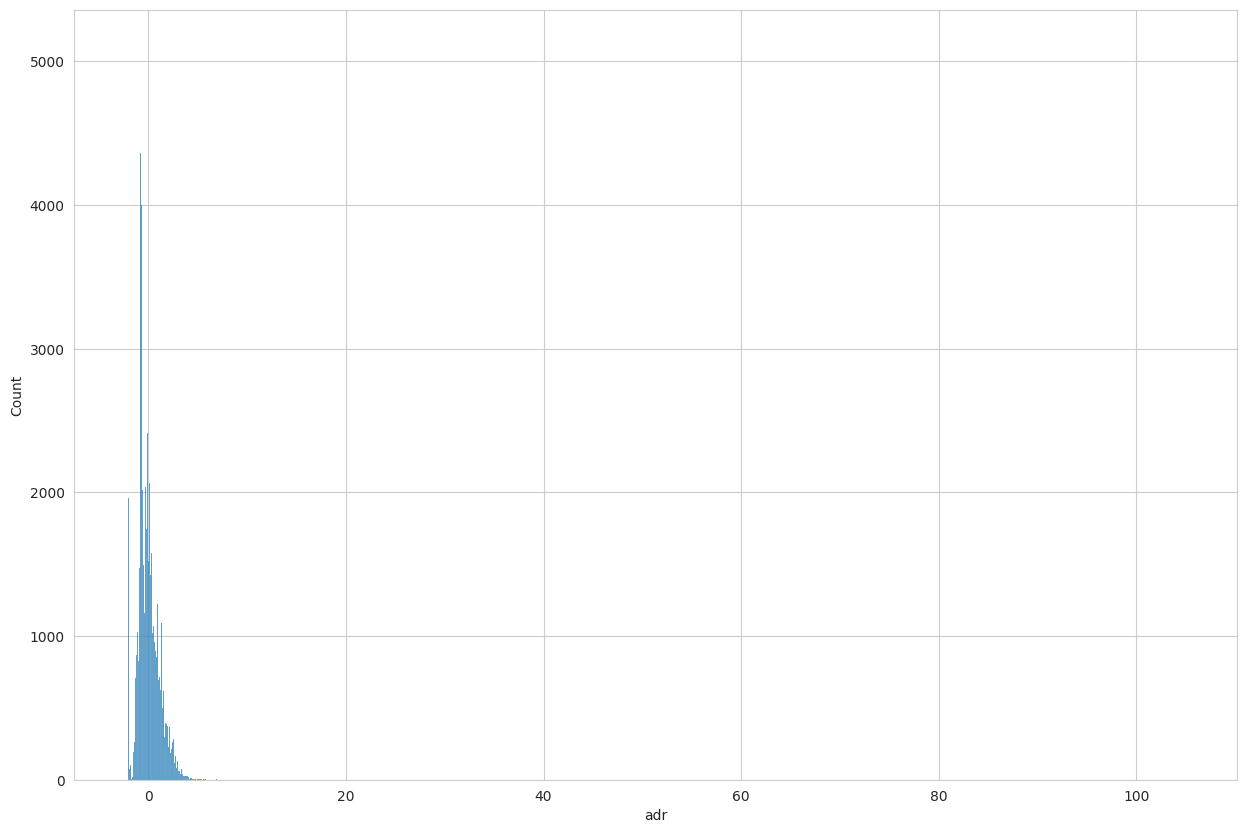

In [13]:
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(dataframe_reservas_hotel_raw["adr"].to_numpy().reshape(-1, 1)), columns=["adr"]

In [70]:
dataframe_reservas_hotel_raw[dataframe_reservas_hotel_raw["children"].isna()][["children"]]

,children
40600,NaN
40667,NaN
40679,NaN
41160,NaN


In [136]:
pd.DataFrame(dataframe_reservas_hotel_raw[["reserved_room_type", "assigned_room_type",]].value_counts())

,,0
reserved_room_type,assigned_room_type,
A,A,73598
D,D,17736
A,D,7548
E,E,5923
F,F,2707
...,...,...
L,C,1
H,D,1
L,A,1


In [74]:
dataframe_reservas_hotel_raw["children"].isna().sum()

4

In [144]:
selector = VarianceThreshold()
selector.fit_transform(dataframe_reservas_hotel_raw[["is_canceled"]])

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [149]:
selector.get_feature_names_out()

array(['is_canceled'], dtype=object)

## Pipeline Feature Engineering

In [ ]:
processor1 = DataProcessor(client=ml_client, data=dataframe_reservas_hotel_raw)
processor1.process()

In [21]:
processor2 = DataProcessor(client=ml_client2, data=dataframe_reservas_hotel_raw)
processor2.process()

[]


In [22]:
processor.data

,is_canceled,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,lead_time,adr,days_in_waiting_list
0,0.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.227051,-2.015038,-0.131924
1,0.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.923385,-2.015038,-0.131924
2,0.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.907814,-0.530935,-0.131924
3,0.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.851667,-0.530935,-0.131924
4,0.0,27.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.842309,-0.075810,-0.131924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0.0,35.0,30.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.758089,-0.112616,-0.131924
119386,0.0,35.0,31.0,2.0,5.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.018822,2.445779,-0.131924
119387,0.0,35.0,31.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.655153,1.105733,-0.131924
119388,0.0,35.0,31.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.046682,0.050833,-0.131924


In [6]:
processor.data.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.00000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,...,0.005034,0.000050,0.000101,0.876464,0.122179,0.001357,0.03414,0.004833,0.750591,0.210436
std,0.482918,106.863097,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,...,0.070772,0.007089,0.010025,0.329053,0.327494,0.036811,0.18159,0.069351,0.432673,0.407620
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
75%,1.000000,160.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [23]:
processor.write(version=4)

Uploading feature_engineering_data_PROCESSED.csv (< 1 MB): 100%|██████████| 38.9M/38.9M [00:00<00:00, 96.8MB/s]




In [24]:
test_gold_data = ml_client.data.get("gold-booking-dsrp", version="3")
pd.read_csv(test_gold_data.path)

,is_canceled,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,lead_time,adr,days_in_waiting_list
0,0.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.227051,-2.015038,-0.131924
1,0.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.923385,-2.015038,-0.131924
2,0.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.907814,-0.530935,-0.131924
3,0.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.851667,-0.530935,-0.131924
4,0.0,27.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.842309,-0.075810,-0.131924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0.0,35.0,30.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.758089,-0.112616,-0.131924
119386,0.0,35.0,31.0,2.0,5.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.018822,2.445779,-0.131924
119387,0.0,35.0,31.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.655153,1.105733,-0.131924
119388,0.0,35.0,31.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.046682,0.050833,-0.131924
